This notebook explains how to use **Lernd** - my implementation of $\partial$ILP framework.

I will not go into too many details of this implementation here. If interested, I suggest looking at the source code and,
especially, unit tests where I used examples straight from the original $\partial$ILP paper $-$
[Learning Explanatory Rules from Noisy Data](https://arxiv.org/abs/1711.04574).

Prior to reading this you should be familiar with Inductive Logic Programming (ILP), which is succinctly explained in
the original $\partial$ILP paper.

### $\partial$ILP $-$ Differential Inductive Logic Programming Framework
Briefly, in $\partial$ILP all the non-differentiable work is done in advance, producing apparatus for numerical,
differentiable forward chaining. Optimization algorithm is run where loss is evaluation of forward chaining results.
Automatic differentiation is used to calculate the gradients. Forward chaining is adjusted by the weight matrices, and,
in turn, these weights can be adjusted. In the end, results (predicate definitions) are extracted from the weight
matrices.


To show how Lernd works, I will walk you through the simple problem of learning the "predecessor" relation. Lernd will
learn it by using just a few examples and background facts.

First the problem needs to expressed in ILP terms. We need to define a language frame and a program template.

Formally, a language frame $\mathcal{L}$ is a tuple $(target, P_e, arity_e, C)$, where $target$ is an intensional target
predicate, $P_e$ is a set of extensional predicates, $arity_e$ is an arity map of predicates, $C$ is a set of constants.

In Lernd `LanguageModel` corresponds to $\mathcal{L}$. Here we define a language frame for the predecessor problem:
* The $target$ is an intensional predicate we want to learn.
* Constants are just natural numbers 0 to 9.
* We have 2 extensional predicates, a monadic $zero$ predicate, and a successor relation - a dyadic predicate $succ$.

We don't need to worry about $arity_e$ mapping, since arity is part of the predicate definition in this
implementation.

In [1]:
import os

import tensorflow as tf

from lernd.classes import GroundAtoms, ILP, LanguageModel, MaybeGroundAtom, ProgramTemplate
from lernd.lernd_loss import Lernd
from lernd.lernd_types import Constant, RuleTemplate, Predicate
from lernd.main import generate_weight_matrices, extract_definitions, print_valuations
from lernd.util import ground_atom2str, str2ground_atom, str2pred, get_ground_atom_probs

os.environ['CUDA_VISIBLE_DEVICES'] = ''

target_pred = str2pred('predecessor/2')
zero_pred = str2pred('zero/1')
succ_pred = str2pred('succ/2')
preds_ext = [zero_pred, succ_pred]
constants = [Constant(str(i)) for i in range(10)]
language_model = LanguageModel(target_pred, preds_ext, constants)

Program template $\Pi$ is a tuple $(P_a, arity_a, rules, T)$ where $P_a$ is a set of invented (auxiliary) intensional
predicates, $rules$ - a map of predicate $p$ to a pair of rule templates $(\tau_p^1, \tau_p^2)$.

Note that in cases where an intensional predicate $p$ is fully expressed in just one clause, rule template $\tau_p^2$
should be $null$ (more on this later).

Rule template $\tau$ is a tuple $(v, int)$, which describes the range of clauses that can be generated ($v$ - a number
of existentially quantified variables allowed in the clause, $int \in \{0, 1\}$ - whether intensional predicates are
allowed).

Program template is actually a hyperparameter, since it needs to be given in advance and is problem specific. It is
possible to use iterative deepening (as per $\partial$ILP paper), but this increases the amount of computation
massively. Iterative deepening is currently not implemented in Lernd.

In [2]:
preds_aux = []
rules = {target_pred: (RuleTemplate((0, False)), None)}
forward_chaining_steps = 1
program_template = ProgramTemplate(preds_aux, rules, forward_chaining_steps)

Background axioms (ground atoms), positive and negative examples are also part of the ILP problem definition.

Define background axioms - $zero(0)$ and $succ$ examples, as well as positive examples:

In [3]:
ground_zero = str2ground_atom('zero(0)')
background_axioms = [ground_zero] + [str2ground_atom(f'succ({i},{i + 1})') for i in range(9)]
positive_examples = [str2ground_atom(f'predecessor({i + 1},{i})') for i in range(9)]
print('Background axioms:')
print('\n'.join(map(ground_atom2str, background_axioms)))
print('\nPositive examples:')
print('\n'.join(map(ground_atom2str, positive_examples)))

Background axioms:
zero(0)
succ(0,1)
succ(1,2)
succ(2,3)
succ(3,4)
succ(4,5)
succ(5,6)
succ(6,7)
succ(7,8)
succ(8,9)

Positive examples:
predecessor(1,0)
predecessor(2,1)
predecessor(3,2)
predecessor(4,3)
predecessor(5,4)
predecessor(6,5)
predecessor(7,6)
predecessor(8,7)
predecessor(9,8)


In this case, negative examples are all other $predecessor$ substitutions ($\mathcal{P}$ being a set of positive
examples):

$\mathcal{N} = \{predecessor(X,Y) \mid (X,Y) \in \{0,\ldots,9\}^2\} - \mathcal{P}$

Here I take advantage of Lernd's `ground_atom_generator` to define it:

In [4]:
ground_atoms = GroundAtoms(language_model, program_template)
negative_examples = []
for ground_atom, _ in ground_atoms.ground_atom_generator(MaybeGroundAtom.from_pred(target_pred)):
    if ground_atom not in positive_examples:
        negative_examples.append(ground_atom)
print('Negative examples:')
print('\n'.join(map(ground_atom2str, negative_examples)))

Negative examples:
predecessor(0,0)
predecessor(0,1)
predecessor(0,2)
predecessor(0,3)
predecessor(0,4)
predecessor(0,5)
predecessor(0,6)
predecessor(0,7)
predecessor(0,8)
predecessor(0,9)
predecessor(1,1)
predecessor(1,2)
predecessor(1,3)
predecessor(1,4)
predecessor(1,5)
predecessor(1,6)
predecessor(1,7)
predecessor(1,8)
predecessor(1,9)
predecessor(2,0)
predecessor(2,2)
predecessor(2,3)
predecessor(2,4)
predecessor(2,5)
predecessor(2,6)
predecessor(2,7)
predecessor(2,8)
predecessor(2,9)
predecessor(3,0)
predecessor(3,1)
predecessor(3,3)
predecessor(3,4)
predecessor(3,5)
predecessor(3,6)
predecessor(3,7)
predecessor(3,8)
predecessor(3,9)
predecessor(4,0)
predecessor(4,1)
predecessor(4,2)
predecessor(4,4)
predecessor(4,5)
predecessor(4,6)
predecessor(4,7)
predecessor(4,8)
predecessor(4,9)
predecessor(5,0)
predecessor(5,1)
predecessor(5,2)
predecessor(5,3)
predecessor(5,5)
predecessor(5,6)
predecessor(5,7)
predecessor(5,8)
predecessor(5,9)
predecessor(6,0)
predecessor(6,1)
predecessor(

All of that together constitutes an ILP problem:

In [5]:
ilp_problem = ILP(language_model, background_axioms, positive_examples, negative_examples)

Now we can initialize `Lernd`. On initialization it will perform all the non-differentiable operations, mainly the
generation of $X_c$ tensors (one for each generated clause). These tensors hold indices of ground atoms that satisfy the
clause, and thus enable forward chaining. For more details, see the paper.

In [6]:
lernd_model = Lernd(ilp_problem, program_template)

Generating clauses...
Generating ground atoms...
Making big lambda...
Generating initial valuation...
Initializing Inferrer
Inferrer initializing xc tensors...


Now we are ready to start the training. We initialize the weights.

We are using `RMSProp` optimization as suggested in the paper. All other hyperparameter values are also taken from the
paper. The only exceptions are the number of steps (100 here instead of 6000) and `clause_prob_threshold` (which is the
probability needed for us to extract the clauses). If it does not reach the set 0.1, I extract clauses with max
probability.

In [7]:
weights = generate_weight_matrices(lernd_model.clauses)
losses = []
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.5)

im = None
for i in range(1, 301):
    loss_grad, loss, valuation = lernd_model.grad(weights)
    optimizer.apply_gradients(zip(loss_grad, list(weights.values())))
    loss_float = float(loss.numpy())
    losses.append(loss_float)
    if i % 10 == 0:
        print(f'Step {i} loss: {loss_float}\n')

Instructions for updating:
Use tf.identity instead.
Step 10 loss: 0.002392948605120182

Step 20 loss: 0.0008582102600485086

Step 30 loss: 0.00041325189522467554

Step 40 loss: 0.0002204662887379527

Step 50 loss: 0.00012332119513303041

Step 60 loss: 7.068274135235697e-05

Step 70 loss: 4.105755579075776e-05

Step 80 loss: 2.403229518677108e-05

Step 90 loss: 1.4134382581687532e-05

Step 100 loss: 8.341397915501148e-06

Step 110 loss: 4.933589480060618e-06

Step 120 loss: 2.912918489528238e-06

Step 130 loss: 1.7279525081903557e-06

Step 140 loss: 1.0323573178538936e-06

Step 150 loss: 6.192939849825052e-07

Step 160 loss: 3.6418495596990397e-07

Step 170 loss: 2.2292158519121585e-07

Step 180 loss: 1.4126310077244852e-07

Step 190 loss: 9.17911862075016e-08

Step 200 loss: 5.96046660916727e-08

Step 210 loss: 3.3378604769040976e-08

Step 220 loss: 2.2053722403825304e-08

Step 230 loss: 2.1457676524505587e-08

Step 240 loss: 1.0728836485895954e-08

Step 250 loss: 1.0728836485895954e-0

Let's plot the loss to see how it went. Basically, this simple problem is solved in under 10 training steps, and if run
for 300 steps, loss converges to exactly 0.

Text(0, 0.5, 'Value')

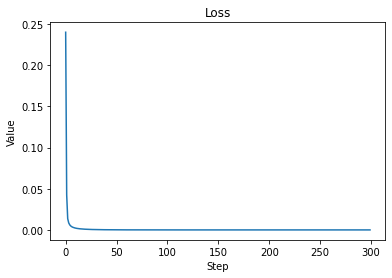

In [8]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title('Loss')
ax.set_xlabel('Step')
ax.set_ylabel('Value')

Finally let's extract the results:

In [9]:
extract_definitions(lernd_model.clauses, weights)
ground_atom_probs = get_ground_atom_probs(valuation, lernd_model.ground_atoms)
print_valuations(ground_atom_probs)

clause_prob_threshold: 0.1

Clause learnt:
With probability (confidence): 1.0
predecessor(A,B)<-succ(B,A), succ(B,A)

Valuations of ground atoms (only those >0.01 for readability):
zero(0) - 1.0
succ(0,1) - 1.0
succ(1,2) - 1.0
succ(2,3) - 1.0
succ(3,4) - 1.0
succ(4,5) - 1.0
succ(5,6) - 1.0
succ(6,7) - 1.0
succ(7,8) - 1.0
succ(8,9) - 1.0
predecessor(1,0) - 1.0
predecessor(2,1) - 1.0
predecessor(3,2) - 1.0
predecessor(4,3) - 1.0
predecessor(5,4) - 1.0
predecessor(6,5) - 1.0
predecessor(7,6) - 1.0
predecessor(8,7) - 1.0
predecessor(9,8) - 1.0


Obviously, this is a simple problem with no noise in the data, so the next notebook will demonstrate how lernd solves a
more difficult problem.